# Aircraft Configuration GP example

This notebook is designed to test whether a simple simple comprised of bounding boxes can be generated using [deap](http://deap.readthedocs.io/en/master/api/tools.html), a Python Evolutionary Algorithm Package.

In [ ]:
import numpy as np
import pydot
from airconics.topology import Topology_GPTools

from IPython.display import Image, display

from airconics.Addons.WebServer.TornadoWeb import TornadoWebRenderer

In [ ]:
topo_tools = Topology_GPTools()
# Try to compile a single individual and visualise both the tree and geometry
topo = topo_tools.randomize()

print(topo)

renderer = TornadoWebRenderer()
topo.Display(renderer)

renderer

In [ ]:
Image(topo.pydot_graph().create_png())

In [ ]:
expr_string = """fuselage1(0., 0., 0., 1.0, 0.182, 0.293, 0.5, mirror2(
    liftingsurface0(0., 0., 0., 1., 0.68, 0., AirlinerTP),
    liftingsurface0(0.55, 0., 0., 1., 0.5, 0.28, AirlinerFin)))"""
config2 = topo_tools.from_string(expr_string)

print(config2)

from airconics.Addons.WebServer.TornadoWeb import TornadoWebRenderer

renderer = TornadoWebRenderer()

config2.Display(renderer)

renderer



In [ ]:
# config2.Write('GP_output.step')
graph = config2.pydot_graph()
Image(graph.create_png())

repr(config2._deap_tree)

In [ ]:
# For now, I'll have to do this by hand...
graph = """digraph G {
ranksep="0.1";
nodesep="0.1";
# splines=ortho;
node [style=filled];
edge [arrowhead=none];
subgraph cluster_standard {
color=invis;
0 [shape=ellipse, fillcolor="#136ed4", label=fuselage1, fontcolor="white"];
1 [shape=ellipse, label=<X<SUB>0</SUB>>];
2 [shape=ellipse, label=<Y<SUB>0</SUB>>];
3 [shape=ellipse, label=<Z<SUB>0</SUB>>];
4 [shape=ellipse, label=<SF>];
5 [shape=ellipse, label=<L<SUB>N</SUB>/L>];
6 [shape=ellipse, label=<L<SUB>T</SUB>/L>];
7 [shape=ellipse, label="L/D"];
8 [shape=box, fillcolor="#136ed4", label="mirror2", fontcolor="white"];
}

subgraph cluster_mirrored {
style=dashed;
9 [shape=box, fillcolor="#136ed4", label=liftingsurface0, fontcolor="white"];
10 [shape=ellipse, label=<<O>X</O><SUB>1</SUB>>];
11 [shape=ellipse, label=<<O>Y</O><SUB>1</SUB>>];
12 [shape=ellipse, label=<<O>Z</O><SUB>1</SUB>>];
13 [shape=ellipse, label=<<O>SF</O><SUB>1</SUB>>];
20 [shape=ellipse, label=<Shape_functs<SUB>1</SUB>>];

rank=same;
14 [shape=box, fillcolor="#136ed4", label=liftingsurface0, fontcolor="white"];
15 [shape=ellipse, label=<<O>X</O><SUB>2</SUB>>];
16 [shape=ellipse, label=<<O>Y</O><SUB>2</SUB>>];
17 [shape=ellipse, label=<<O>Z</O><SUB>2</SUB>>];
18 [shape=ellipse, label=<<O>SF</O><SUB>2</SUB>>];
21 [shape=ellipse, label=<Shape_functs<SUB>2</SUB>>];
}

0 -> 8;
8-> 9;
8 -> 14;

0 -> 1;
0 -> 2;
0 -> 3;
0 -> 4;
0 -> 5;
0 -> 6;
0 -> 7;
# 0 -> 9;
# 0 -> 14;
9 -> 10;
9 -> 11;
9 -> 12;
9 -> 13;
9-> 20;
14 -> 15;
14 -> 16;
14 -> 17;
14 -> 18;
14->21;
}
"""
dotgraph = pydot.graph_from_dot_data(graph)
# dotgraph.write_svg('/home/pchambers/Documents/PhD/SABTalk_2017/images/tree1.svg')
Image(dotgraph.create_png())

In [ ]:
# dotgraph.write_pdf('/home/pchambers/Documents/PhD/Aviation2017/aviation_2017_paper/figure/gplayout_tree2.pdf')

## Conventional Airliner

In [ ]:
topo_tools = Topology_GPTools()
expr_string = """fuselage2(0.3, 0., 0., 1., 0.293, 0.183, 0.8, 
            liftingsurface0(0.55, 0., 0.6, 1., 0.45, 1.0, AirlinerFin) mirror2(
                liftingsurface0(0.7, 0., 0.5, 1.0, 0.35, 0., AirlinerTP), liftingsurface1( 0.15, 0., 0.05, 1., 0.8, 0., AirlinerWing,
                engine0(0.35, 0.9, 1/1.95, 0., 0.8, 0.))))"""

topo = topo_tools.from_string(expr_string)

renderer = TornadoWebRenderer()

topo.Display(renderer)

display(Image(topo.pydot_graph().create_png()))

renderer


In [ ]:
from OCC.gp import gp_Pnt
p1 = gp_Pnt(0,1,1)
try:
    gp_Pnt(p1)
except TypeError:
    assert(isinstance(p1, gp_Pnt))

## General Atomics MQ-1 Predator

### Aircraft configuration from JSON files

User defined JSON can be used to create new component hierarchies using the `Topology_GPTools.from_file` or `from_JSON` methods. This offers an interface for describing new aircraft layouts that is human-readable. The format is described in the table below; see the [presets directory](https://github.com/p-chambers/occ_airconics/tree/v0.3-dev/airconics/resources/configuration_app/presets) on github for examples.

<b>Notes:
* Attributes are not order sensitive, but each of the named attributes must appear once
* The `<N>` should be replaced with a number describing the number of descendent
* The order that component fitting primitives appear in the JSON file DOES affect the result
    - If a component with two sub attachments (`liftingsurface2`) appears in the file, the following two components will be sub geometries of that lifting surface. 
* Scalar variable inputs are all expected to lie between 0 and 1, unless otherwise specified; this dimensionless value is then used to fit the geometry to its parent.
* The lifting surface `Type` attribute can be any of keys the pre-defined wing types `airconics.topology.LSURF_FUNCTIONS` dictionary, e.g., `"AirlinerWing"`, `"TaperedWing"`, etc.
</b>.

<table>
	<col width="3">
	<col width="6">
	<tr>
		<th>Primitive Name</th>
		<th>Attributes</th>
	</tr>
	<tr>
		<td>liftingsurfaceN</td>
		<td>$X$ : longitudinal position, scalar<br>
$Y$ : lateral position, scalar<br>
$Z$ : vertical position, scalar<br>
ChordFactor : scalar<br>
ScaleFactor : scalar<br>
Rotation : scalar (−1 < Rotation < 1)<br>
Type : wing type, string (see **notes** above)</td>
	</tr>
	<tr>
		<td>fuselageN</td>
		<td>$X$ : longitudinal position, scalar<br>
$Y$ : lateral position, scalar<br>
$Z$ : vertical position, scalar<br>
XScaleFactor : scalar<br>
NoseLengthRatio : scalar<br>
TailLengthRatio : scalar<br>
FinenessRatio : scalar	</td>
	</tr>
	<tr>
		<td>mirrorN</td>
		<td>None. This primitive simply mirrors N direct descendants, and their associated subtrees, in the $XZ$ plane.</td>
	</tr>
</table>


We'll use the [predator example](https://github.com/p-chambers/occ_airconics/blob/v0.3-dev/airconics/resources/configuration_app/presets/predator.json) here for demonstration.

In [ ]:
import os, airconics

topo_tools = Topology_GPTools(MaxAttachments=4)

print(os.path.join(os.path.dirname(airconics.__file__)))

fname = os.path.join(os.path.dirname(airconics.__file__),'resources/configuration_app/presets/predator.json')

topo = topo_tools.from_file(fname)

renderer = TornadoWebRenderer()

topo.Display(renderer)

display(Image(topo.pydot_graph().create_png()))

renderer

Why not also try creating one from scratch? Let's aim for the Scaled Composites Proteus:

![SC Proteus aircraft](Proteus.jpg)
**Photo source: NASA**

27.0


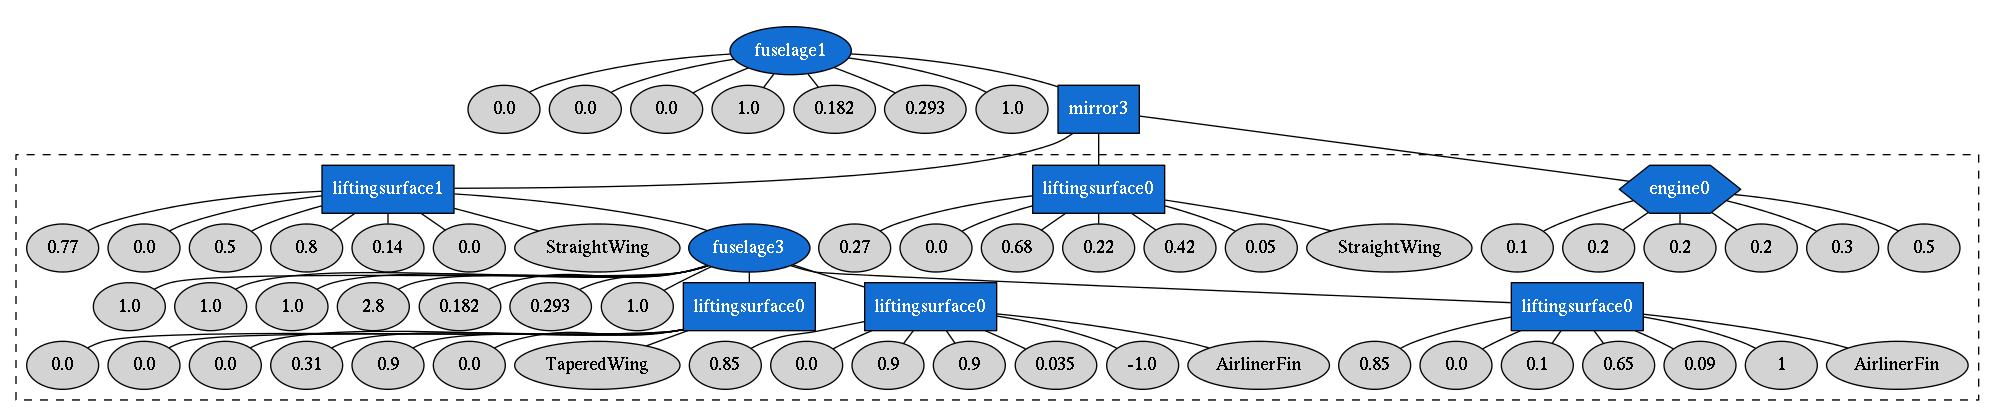

<TornadoWebRenderer at http://PChambers_ngcm:39683/get/b2bd92a3955346cca9393b70ef8d49d9>

In [1]:
import os, airconics
import numpy as np
import pydot
from airconics.topology import Topology_GPTools
from IPython.display import Image, display
from airconics.Addons.WebServer.TornadoWeb import TornadoWebRenderer

# Note that we don't have to do anything special to turn a list of
# dictionaries into json format before calling topo_tools.from_json:
#  The primtives_array is already in json format!
primitives_array = [
  {
    "primitive": "fuselage1", 
    "args": {
        "X": 0.0, 
        "Y": 0.0, 
        "Z": 0.0,
        "XScaleFactor": 1.0,
        "NoseLengthRatio": 0.182,
        "TailLengthRatio": 0.293,
        "FinenessRatio": 1.0
      }
  },
  {
    "primitive": "mirror3"
  }, 
  {
    "primitive": "engine0",
    "args":{
        "SpanStation": 0.8,
        "XChordFactor": 0.2,
        "DiameterLenRatio": 0.2,
        "PylonSweep": 0.2,
        "PylonLenRatio": 0.3,
        "Rotation": 0.5
    }
  },
  {
    "primitive": "liftingsurface0",
    "args": {
        "X": 0.27, 
        "Y": 0.0, 
        "Z": 0.68,     
        "ScaleFactor": 0.42,
        "ChordFactor": 0.22,
        "Rotation": 0.05, 
        "Type": "StraightWing"
    }
  },
  {
    "primitive": "liftingsurface1", 
    "args": {
        "X": 0.77,
        "Y": 0.0, 
        "Z": 0.5, 
        "ChordFactor": 0.8, 
        "ScaleFactor": 0.14,
        "Rotation": 0.0, 
        "Type": "StraightWing"
    }
  },
  {
    "primitive": "fuselage3", 
    "args": {
        "X": 1.0, 
        "Y": 1.0, 
        "Z": 1.0,
        "XScaleFactor": 2.8,
        "NoseLengthRatio": 0.182,
        "TailLengthRatio": 0.293,
        "FinenessRatio": 1.0
    }
  }, 
  {
    "primitive": "liftingsurface0",
    "args": {
        "X": 0.0, 
        "Y": 0.0, 
        "Z": 0.0,     
        "ScaleFactor": 0.9,
        "ChordFactor": 0.31,
        "Rotation": 0.0, 
        "Type": "TaperedWing"
    }
  },

  {
    "primitive": "liftingsurface0",
    "args": {
        "X": 0.85,
        "Y": 0.0, 
        "Z": 0.9, 
        "ChordFactor": 0.9,
        "ScaleFactor": 0.035,
        "Rotation": -1.0, 
        "Type": "AirlinerFin"
    }
  }, 
  {
    "primitive": "liftingsurface0",
    "args": {
        "X": 0.85,
        "Y": 0.0, 
        "Z": 0.1, 
        "ChordFactor": 0.65, 
        "ScaleFactor": 0.09,
        "Rotation": 1, 
        "Type": "AirlinerFin"
    }
  }
]

topo_tools = Topology_GPTools(MaxAttachments=3)
topo = topo_tools.from_json(primitives_array)


renderer = TornadoWebRenderer()

topo.Display(renderer)

display(Image(topo.pydot_graph().create_png()))

renderer

## Optimisation

**Note**: The optimisation setup code provided here is already included in the `Topology_GPTools` class, and can be used as default via the `Topology_GPTools.optimize` method. It is included here for those interested in how the evolutionary algorithm operates.

### The Objective Function

User-defined functions for the topology optimisation are catered for in the `Topology_GPTools` class. The function should take in a `Topology` (See: `airconics.topology.Topology`), and return a single number: default behaviour is that this measure of fitness will be maximised, i.e., topologies with a greater value returned by this function will be selected more favourably for mutation, reproduction, etc.

The objective function shown below will be used to maximise the similarity of an individuals component tree to a reference case: the airliner model. With this setup, the evolutionary algorithm will be subject to a simple test case for the genetic algorithm: that is, to test if the evolutionary process can obtain a given solution, without giving it any knowledge of what the solution is.

Considering that 'success' in this case would be achieved if the algorithm yields a geometry and configuration that is suitably (visually?) similar to the airliner model, results of interest should be,

* what population size, and number of generations gives a good probability of 'success'
* 

In [ ]:
from airconics.topology import Topology_GPTools
import os
import numpy as np
from IPython.display import Image, display
from airconics.Addons.WebServer.TornadoWeb import TornadoWebRenderer
import airconics

def create_diffed_airliner_fitness():
    """
    Produces a fitness function for checking the similarity of an input
    airconics topology with a reference: the airliner example.

    Uses difflib's gestalt pattern matching algorithms.

    Returns
    -------~
    diffed_fitness : function
        A function which takes an airconics topology as its input

    Notes
    -----
    * This function is used so that the reference geometry/layout needs to
    be created once only.
    
    * Eventually this function should use some information from the
    geometry model, e.g., total wing area, as part of the objective function.
    """
    # Create the reference list of primitive strings
    topo_tools = Topology_GPTools(MaxAttachments=4)
    fname = os.path.join(os.path.dirname(airconics.__file__),
                         'resources/configuration_app/presets/airliner.json')
    topo = topo_tools.from_file(fname)
    
    # Obtain a list of all component primitives in the tree
    airliner_json = topo.to_json()

    airliner_components = [node['primitive'] for node in airliner_json]

    def diffed_airliner_fitness(topology):
        """Currently just uses difflibs gestalt pattern matcher. Eventually,
        this should use data from the inputs of the matched components 
        """
        import difflib

        tree_json = topology.to_json()
        tree_components = [node['primitive'] for node in tree_json]

        sm = difflib.SequenceMatcher(None, tree_components, airliner_components)
        
        # Will give something in order 0-10, 0 being exactly the same
        diff = (1-sm.ratio()) * 10

        for match in sm.get_matching_blocks()[:-1]:

            for i in range(match.size):
                argsa = tree_json[match.a + i]['args']
                diff_vector = np.zeros(len(argsa))
                if len(argsa) > 0:
                    # This node is not a mirror, and inputs may have some difference
                    argsb = airliner_json[match.b + i]['args']

                    # Try and get the shape difference only:
                    try:
                        # if this works, it's a wing
                        diff += (1 if argsa['Type'] != argsb['Type'] else 0)
                    except KeyError:
                        # If not, it's a fuselage
                        pass
                    
                    for j, (key, val) in enumerate(argsb.items()):
                        try: 
                            diff_vector[j] = abs(val - argsa[key])
                        except TypeError:
                            # This is probably the string parameter (eg wing type)
                            pass
                    diff += np.linalg.norm(diff_vector) / np.linalg.norm(np.ones_like(diff_vector))   # Will give something in the order 1


        return diff
    return diffed_airliner_fitness


diffed_airliner_fitness = create_diffed_airliner_fitness()

In [ ]:
# Check that the fitness function gives back a zero if the tree is exactly the same
topo_tools = Topology_GPTools(MaxAttachments=4)
fname = os.path.join(os.path.dirname(airconics.__file__),
                     'resources/configuration_app/presets/airliner.json')
topo = topo_tools.from_file(fname)

tree_json = topo.to_json()
tree_components = [node['primitive'] for node in tree_json]
val = 10
print(tree_json[1]['args']['Type'])#
print(val)

val += (1 if tree_json[1]['args']['Type'] != 'AirlinerFin' else 0)

print(val)


print(diffed_airliner_fitness(topo))
assert(diffed_airliner_fitness(topo) == 0)

### Evolution Setup

In [ ]:
from deap import tools, gp, algorithms
from airconics.topology import generate_topology
import random 

random.seed(62)

# The below are the default settings for Topology_GPTools, and are
# included for illustration. See docs or help for explanation of inputs
topo_tools = Topology_GPTools(MaxAttachments=4,
                              min_levels=2,
                              max_levels=4,
                              min_mut=1,
                              max_mut=3,
                              fitness_funct=diffed_airliner_fitness,
                             fitness_weights=(-1.0,),
                             history=True)  # Minimization!


# For now, I'll remove the construction of the geometry. This part
# takes time, and the current fitness function doesn't require a
# full CAD model - full scale analysis simulation would leave this in.
def eval_topology_treeonly(individual):
    # simulate a topology run
    topo = airconics.Topology()
    topo._deap_tree = individual
    return diffed_airliner_fitness(topo),

topo_tools._toolbox.register("evaluate", eval_topology_treeonly)


# This is small in GP, but this is used for demonstration purposes.
# Larger scale simulations should have a much larger population.
popsize = 500

import time
t = time.time()
population, logbook, hof, gen_best = topo_tools.optimize(n=popsize, cxpd=0.5, mutpd=0.2, ngen=200)
print("Evolution took {} seconds".format(time.time() - t))

# get the best individual and rerun it:
best = hof[0]
best_topology = topo_tools.run(best)

renderer = TornadoWebRenderer()

best_topology.Display(renderer)

renderer

In [ ]:
display(Image(best_topology.pydot_graph().create_png()))

In [ ]:
# Get the worst individual from the hall of fame (this is actually the 100th best)
last = hof[-1]
    

# get the best individual and rerun it:
last_topology = topo_tools.run(last)

renderer = TornadoWebRenderer()

last_topology.Display(renderer)

renderer

In [ ]:
# Here's some code for creating the network diagram, but the
# diagram doesn't show a lot, and can take a long time to generate:
#  leaving this commented out for now.

# import networkx
# import matplotlib.pyplot as plt
# %matplotlib notebook

# graph = networkx.DiGraph(topo_tools.history.getGenealogy(best))
# graph = graph.reverse()     # Make the grah top-down

# colors = [topo_tools._toolbox.evaluate(topo_tools.history.genealogy_history[i])[0] for i in graph]
# networkx.draw(graph, node_color=colors, show='ipynb')

In [ ]:
import matplotlib.pyplot as plt
%matplotlib notebook
# Write and plot the accompanying statistics of the evolution
gen, best, worst, avg = logbook.select("gen", "min", "max", "avg")
log_array = np.column_stack([gen, best, worst, avg])
# print(log_array)
np.savetxt('log.txt', log_array, header='gen    best(min)    worst    avg')

# Plot
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(gen, best, 'b-', label=r'Best')
ax1.plot(gen, worst, 'r-', label=r'Worst')
ax1.plot(gen, avg, 'g-', label=r'Avg')

ax1.set_xlabel('Generation')
ax1.set_ylabel('Fitness')
ax1.legend(loc="upper right")

In [ ]:
# inds = [topo_tools.run(topo_tools.history.genealogy_history[i]) for i in topo_tools.history.getGenealogy(best)]


## Evolution Animation

Note that the below code does not produce the rendered images of the `.stp` geometry files to be used as frames in the animation: this step is currently done in Rhino, which produces better quality renderings.

In [ ]:
# Write the best geometry in each generation as step
# for i, ind in enumerate(gen_best):
#     topo = topo_tools.run(ind)
#     path = '/home/pchambers/Documents/Vbox_share/gp_geometries'
#     fout = os.path.join(path, 'gen{:03}.stp'.format(i))
#     topo.Write(fout)

## Local optimisation 

In [ ]:
# The below are the default settings for Topology_GPTools, and are
# included for illustration. See docs or help for explanation of inputs
topo_tools = Topology_GPTools(MaxAttachments=4,
                              min_levels=2,
                              max_levels=4,
                              min_mut=1,
                              max_mut=3,
                              fitness_funct=diffed_airliner_fitness,
                             fitness_weights=(-1.0,))  # Minimization!


# For now, I'll remove the construction of the geometry. This part
# takes time, and the current fitness function doesn't require a
# full CAD model - full scale analysis simulation would leave this in.
def eval_topology_treeonly(individual):
    # simulate a topology run
    topo = airconics.Topology()
    topo._deap_tree = individual
    return diffed_airliner_fitness(topo),

topo_tools._toolbox.register("evaluate", eval_topology_treeonly)


# This is small in GP, but this is used for demonstration purposes.
# Larger scale simulations should have a much larger population.
popsize = 200

ngen = 50

history = 

for i in range(ngen)
    topo_tools._toolbox.population, logbook, hof = topo_tools.optimize(
        n=popsize, cxpd=0.5, mutpd=0.2, ngen=100)

# if hof[0].fitness.values() < 1.:
#     Do some local optimisation
best = hof[0]
#     for 
    

# get the best individual and rerun it:
best_topology = topo_tools.run(best)


In [ ]:
from deap import gp
import copy
import types

best = hof[0]
best_copy = copy.deepcopy(best)

n_terms = sum(1 if node issubclass(node, gp.Terminal) else 0 for node in best)

pset2 = PrimitiveSetTyped("TUNING", [float]*nterms, types.NoneType)

for i, node in enumerate(best):
    if issubclass(node, gp.Terminal):
        topo_tools._pset.addTerminal('var{}'.format(i))
        best_copy[i] = variables[-1]
    else:
        


In [ ]:
topo_tools = Topology_GPTools(MaxAttachments=3,
                              min_levels=2,
                              max_levels=4,
                              min_mut=1,
                              max_mut=3,
                              fitness_funct=diffed_airliner_fitness,
                             fitness_weights=(-1.0,),
                             history=True)  # Minimization!

ind = topo_tools._toolbox.individual()
topo = topo_tools.run(ind)
g = topo.pydot_graph()
g.create_fig()
# display(Image(topo.pydot_graph().create_png()))
# 
# renderer = TornadoWebRenderer()
# topo.Display(renderer)
# renderer